# Using the Poisson Distribution to estimate NBA Statistics

The Poisson distribution, given an expected rate of an event occuring, tells us the probability of the event happening k times. For example, if we know that, on average, 5 customers per hour enter a store, if we can assume independence in these events, a Poisson Distribution can be used to model how likely it is that 0, 5, 100, etc. customers enter the store in any given hour. I'll explore whether this distribution is relevant to the rate at which NBA players accumulate counting stats.

My goals for this exercise are to:

- Learn more about the Poisson distribution
- Determine for which, if any, NBA statitics, the distribution can be used as a usable model for prediction
- Learn more about statistical comparison/goodness of fit tests particularly relevant to the Poisson distribution

I'll use four seasons worth of player averages to obtain an expected rate for each statistic for the 2019 season, then determine how closely the player's actual results fit the distribution.

In [480]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urllib2 import urlopen
import math
from scipy import stats
from __future__ import division
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

Begin by scraping all players' season average for the past five seasons. I keep only the players who played a game in all five seasons - rookies and players who haven't played consistenly won't give us as strong of a baseline off of which to set their expected rate for any statistic.

In [407]:
years = np.arange(2014,2019,1)
allData = []
currYear = []

for y in years:
    print y
    url = 'https://www.basketball-reference.com/leagues/NBA_' + str(y)+ '_per_game.html'
    html = urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    column_headers = [th.getText() for th in 
                  soup.findAll('tr', limit=2)[0].findAll('th')]
    column_headers = [x.encode('UTF8') for x in column_headers]
    table_rows = soup.select("#div_per_game_stats tr")
    for row in table_rows:
        indiv_list = []
        for th in row.find_all('th'):
            indiv_list.append(th.get_text().encode('utf-8').strip())
        for td in row.find_all('td'):
            indiv_list.append(td.get_text().encode('utf-8').strip())
        allData.append(indiv_list)
        currYear.append(y)
        
season_averages = pd.DataFrame(allData,columns=column_headers)
season_averages['Year'] = currYear
season_averages = season_averages[season_averages['Player'] != 'Player']

season_averages.drop_duplicates(subset=['Player','Year'],keep='first',inplace=True)


def removeChars(player):
    return re.sub("[^a-zA-Z ]+", "", player)
    
season_averages['Player'] = season_averages['Player'].apply(lambda x:removeChars(x))

season_averages[[u'Age', u'G', u'GS', u'MP', u'FG',
       u'FGA', u'FG%', u'3P', u'3PA', u'3P%', u'2P', u'2PA', u'2P%', u'eFG%',
       u'FT', u'FTA', u'FT%', u'ORB', u'DRB', u'TRB', u'AST', u'STL', u'BLK',
       u'TOV', u'PF', u'PTS', u'Year']] = season_averages[[u'Age', u'G', u'GS', u'MP', u'FG',
       u'FGA', u'FG%', u'3P', u'3PA', u'3P%', u'2P', u'2PA', u'2P%', u'eFG%',
       u'FT', u'FTA', u'FT%', u'ORB', u'DRB', u'TRB', u'AST', u'STL', u'BLK',
       u'TOV', u'PF', u'PTS', u'Year']].apply(pd.to_numeric)

def check_inclusion(player):
    all_years = set(season_averages[season_averages['Player'] == player]['Year'])
    if len(all_years) == 5:
        return player
    
players_to_include = season_averages['Player'].apply(lambda x:check_inclusion(x))
players_to_include = [player for player in list(players_to_include) if player]


season_averages.head()

2014
2015
2016
2017
2018


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
1,1,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,...,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014
4,2,Steven Adams,C,20,OKC,81,20,14.8,1.1,2.3,...,1.8,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,2014
5,3,Jeff Adrien,PF,27,TOT,53,12,18.1,2.7,5.2,...,1.9,3.8,5.8,0.7,0.5,0.7,0.7,2.0,6.8,2014
8,4,Arron Afflalo,SG,28,ORL,73,73,35.0,6.4,13.8,...,0.4,3.2,3.6,3.4,0.5,0.0,2.0,1.9,18.2,2014
9,5,Alexis Ajina,C,25,NOP,56,30,17.0,2.4,4.4,...,1.7,3.3,4.9,0.7,0.4,0.8,1.1,3.3,5.9,2014


Get the game logs for the 2019 season for each player. These will be used to count the frequencies for each statistic.

In [483]:
def get_player_link(player):
    base_url = 'https://www.basketball-reference.com/players/'
    player_split = player.split(' ')
    initial = player_split[1][0]
    first_five_last = player_split[1][0:5]
    first_two_first = player_split[0][0:2]
    built_url = base_url + initial + '/' + first_five_last + first_two_first
    for num in ['01','02','03','04','05']:
        try:
            num_url = built_url + num + '/gamelog/2019'
            html = urlopen(num_url)
            break
        except:
            pass
    
    return num_url

In [484]:
def get_player_logs(url):
    html = urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    table_contents = soup.find("table",{"id":"pgl_basic"})
    
    row_contents = []
    for tr in table_contents.find_all('tr')[1:]:
        td = tr.find_all('td')
        row = [tr.text for tr in td]
        row_contents.append(row)

    headers = []
    for header in table_contents.find_all('thead')[0].find_all('th'):
        headers.append(header.get_text().encode('utf-8'))

    game_logs = pd.DataFrame(row_contents, columns=headers[1:])
    return game_logs, headers[1:]  

In [485]:
def scrape_logs(players_to_include):
    all_players_df = pd.DataFrame()
    failed_players = []
    for player in set(players_to_include):
        print player
        url = get_player_link(player)
        try:
            player_logs, headers = get_player_logs(url)
        except Exception as e:
            failed_players.append(player + '--' + str(e))
            pass
        player_logs['player'] = player
        if len(all_players_df.columns) == 0:
            all_players_df = pd.DataFrame(columns=headers.append('player'))
        all_players_df = all_players_df.append(player_logs)
    
    return all_players_df, failed_players
        

#all_players_df, failed_players = scrape_logs(players_to_include)

In [486]:
#all_players_df.to_csv('all_player_logs.csv',index=None)
all_players_df = pd.read_csv('all_player_logs.csv')

In [490]:
all_players_df[all_players_df['player'] == 'Damian Lillard'].head()

,G,Date,Age,Tm,,Opp,.1,GS,MP,FG,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,player
5801,1.0,2018-10-18,28-095,POR,NaN,LAL,W (+9),1,35:24,9.0,...,6.0,4.0,1.0,1.0,3.0,0.0,28.0,20.6,-8.0,Damian Lillard
5802,2.0,2018-10-20,28-097,POR,NaN,SAS,W (+13),1,30:16,9.0,...,2.0,9.0,0.0,0.0,0.0,0.0,29.0,29.0,18.0,Damian Lillard
5803,3.0,2018-10-22,28-099,POR,NaN,WAS,L (-1),1,40:32,7.0,...,8.0,8.0,1.0,0.0,5.0,1.0,29.0,19.9,1.0,Damian Lillard
5804,4.0,2018-10-25,28-102,POR,@,ORL,W (+14),1,36:09,13.0,...,7.0,6.0,1.0,0.0,1.0,0.0,41.0,36.4,15.0,Damian Lillard
5805,5.0,2018-10-27,28-104,POR,@,MIA,L (-9),1,36:52,15.0,...,7.0,6.0,0.0,0.0,1.0,3.0,42.0,33.3,-1.0,Damian Lillard


To perform analysis at a higher level, I'll break the statistic being analyzed into 20 bins so that each local mean for the given statistic is used to generate the poisson distribution for all players in that bin. This is of course inexact, but helps to provide a more general analysis, as well as provide more data rather than using a single player's logs, in most cases.

The average of each player's past 5 seasons for that statistic is used as the rate to expect for 2019. This is a quick proxy for projecting the statistic for each player that should serve its purpose here.

I'll use Offensive Rebounds in these examples.

In [491]:
stats_to_analyze = ['FG','3P','FT','ORB','TRB','AST','STL','BLK','TOV','PTS']

In [632]:
def get_stat_bins(stat, season_averages, all_players_df):
    season_averages = season_averages[season_averages['Player'].isin(players_to_include)]
    expected_pg = pd.DataFrame(season_averages.groupby('Player').mean()[stat].sort_values(ascending=False)).reset_index()

    separator = (max(list(expected_pg[stat])) - min((list(expected_pg[stat]))))/20
    bins = list(np.arange(min(expected_pg[stat]) - .05,max(expected_pg[stat]),separator))
    bins.append(max(expected_pg[stat]) + separator)

    bins_df = pd.DataFrame(pd.cut(expected_pg[stat], bins))
    expected_pg['bin'] = bins_df[stat]
    
    bin_means = expected_pg.groupby('bin').mean().reset_index()
    bin_means.rename(columns={stat:'bin_mean'}, inplace=True)
    expected_pg = expected_pg.merge(bin_means, how='left', on='bin')
    
    all_players_df = all_players_df.merge(expected_pg, how='left',left_on='player', right_on='Player')
    return expected_pg, all_players_df

print expected_pg.head(10)
stat = 'ORB'

all_players_df = pd.read_csv('all_player_logs.csv')
expected_pg, all_players_df = get_stat_bins(stat, season_averages, all_players_df)
all_bins = list(set(all_players_df['bin_mean']))


              Player    PTS               bin   bin_mean
0       James Harden  28.26   (28.21, 29.552]  28.260000
1       Kevin Durant  27.42   (26.918, 28.21]  27.420000
2       LeBron James  26.32  (25.626, 26.918]  26.106667
3  Russell Westbrook  26.08  (25.626, 26.918]  26.106667
4      Stephen Curry  25.92  (25.626, 26.918]  26.106667
5   DeMarcus Cousins  25.18  (24.334, 25.626]  25.150000
6      Anthony Davis  25.12  (24.334, 25.626]  25.150000
7     Damian Lillard  24.14  (23.042, 24.334]  23.730000
8      DeMar DeRozan  23.32  (23.042, 24.334]  23.730000
9    Carmelo Anthony  22.40   (21.75, 23.042]  22.273333


In [633]:
all_players_df[all_players_df['player'] == 'PJ Tucker'].head()

,G,Date,Age,Tm,,Opp,.1,GS,MP,FG,...,TOV,PF,PTS,GmSc,+/-,player,Player,ORB_y,bin,bin_mean
11628,1.0,2018-10-17,33-165,HOU,NaN,NOP,L (-19),1,34:19,6.0,...,0.0,2.0,19.0,15.5,-13.0,PJ Tucker,PJ Tucker,1.6,"(1.562, 1.804]",1.7
11629,2.0,2018-10-20,33-168,HOU,@,LAL,W (+9),1,35:39,2.0,...,1.0,4.0,6.0,5.6,-6.0,PJ Tucker,PJ Tucker,1.6,"(1.562, 1.804]",1.7
11630,3.0,2018-10-21,33-169,HOU,@,LAC,L (-3),1,37:12,1.0,...,0.0,4.0,3.0,3.3,8.0,PJ Tucker,PJ Tucker,1.6,"(1.562, 1.804]",1.7
11631,4.0,2018-10-24,33-172,HOU,NaN,UTA,L (-11),1,38:49,2.0,...,1.0,4.0,6.0,6.5,-10.0,PJ Tucker,PJ Tucker,1.6,"(1.562, 1.804]",1.7
11632,5.0,2018-10-26,33-174,HOU,NaN,LAC,L (-20),1,34:04,5.0,...,1.0,1.0,12.0,13.8,-17.0,PJ Tucker,PJ Tucker,1.6,"(1.562, 1.804]",1.7


Now that we have the expected value for offensive rebounds per game for each player, and have grouped each player into bins, we can generate a Poisson distribution to get a sense for the probabilities and subsequent expected totals for each number of offensive rebounds. Put more clearly, we'll generate a distribution for how often we'd expect a player who has historically averaged .69 offensive rebounds per game, for example, to finish a game with 0, 1, 2, 3, etc offensive rebounds. Then, we'll compare those expectations to reality by looking at each player's 2019 game logs. This can be repeated for all bins to get an overall sense for how well a poisson distribution models offensive rebounds.

The assumption of independence for an NBA statistic is an aggressive one - it is difficult to say that a player's production doesn't impact his future ability to accumulate that statistic (a coach may give a player more minutes if he blocks several shots in the previous game, for example). There's also the issue of opponent - maybe a certain team or lineup is more susceptible to giving up certain statistics, or the opponent reacts strategically to a player entering a game coming off a few great games. These are all reasons to believe the Poisson distribution may not be the ideal fit for this dataset, but I'll continue on to see how close we get.

In [634]:
def poisson_dist(rate, max_range):
    odds_dict = {}
    for k in range(int(max_range)):
        odds = math.exp(-rate) * (math.pow(rate, k) / math.factorial(k))
        odds_dict[k] = odds
    return odds_dict

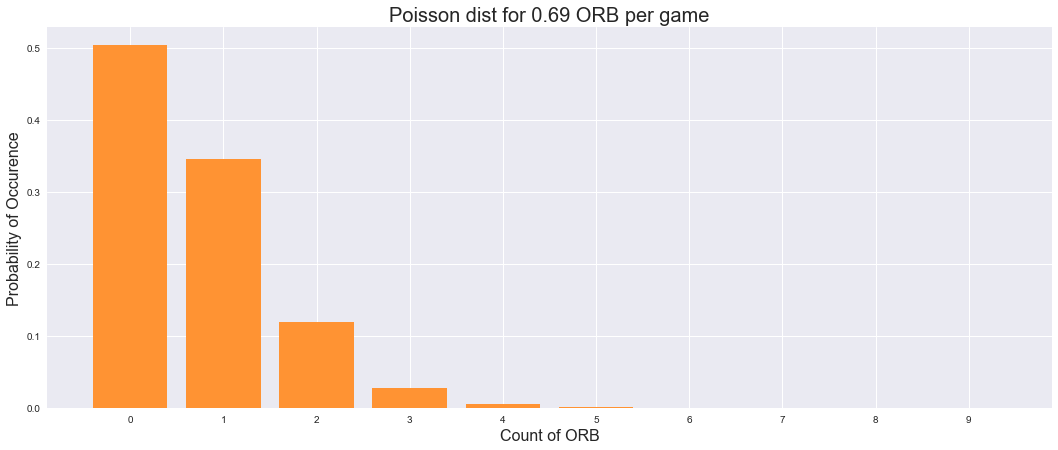

In [635]:
def get_bin_poisson(bin_mean):
    max_range = max(expected_pg['bin_mean']) * 2
    poisson_dict = poisson_dist(bin_mean, max_range)
    
    f, ax = plt.subplots(figsize=(18,7))
    plt.bar(list(poisson_dict.keys()), list(poisson_dict.values()), color='#FF9333')
    plt.title('Poisson dist for ' + str(round(bin_mean,2)) + ' ' + stat + ' per game', fontdict = {'fontsize' : 20})
    plt.xlabel('Count of '+stat, fontdict = {'fontsize' : 16})
    plt.ylabel('Probability of Occurence', fontdict = {'fontsize' : 16})
    plt.xticks(poisson_dict.keys())
    plt.show()
    return poisson_dict

poisson_dict = get_bin_poisson(all_bins[6])

The graph above shows the Poisson distribution for a rate of 0.69. Below, the same plot is shown along with the observed values for the group of players averaging ~0.69 offensive rebounds per game. The observed and Poisson distributions seem to have a similar shape. I'll hypothesize about why & how much they differ below, and look into how we can test the goodness of fit.

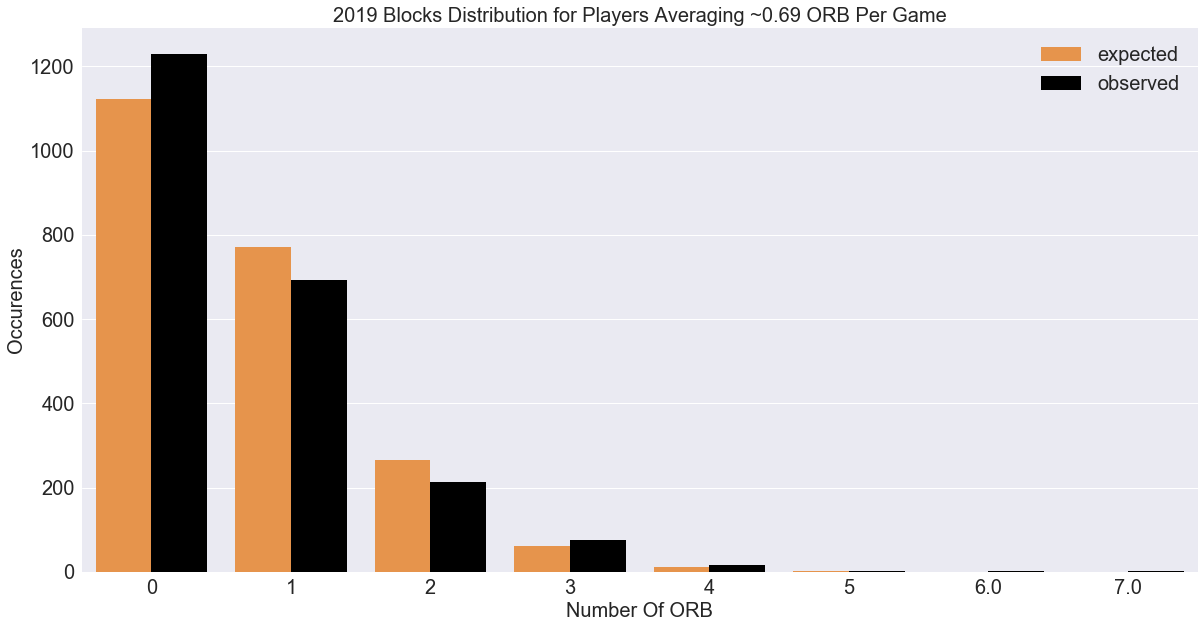

In [636]:
def get_both_distributions(bin_mean, plot = True, eliminate_small = True):
    player_df = all_players_df[(all_players_df['bin_mean'] == bin_mean) & (pd.notnull(all_players_df[stat+'_y']))]
    log = list(player_df[stat+'_x'])
    log = [i for i in log if not np.isnan(i)]
    counts = dict(Counter(log))
    max_stat = max(counts.keys())
    for num in range(int(max_stat)):
        if num not in counts.keys():
            counts[num] = 0
    observed = counts.values()
    expected = [len(log) * i for i in poisson_dist(bin_mean, max(expected_pg['bin_mean']) * 2).values()]
    if eliminate_small:
        expected = [i for i in expected if i > .5]
    
    if plot:
        colors = ["#FF9333", "#000000"]
        sns.set_palette(sns.color_palette(colors))
        plot_df = pd.DataFrame(columns=['count','data','type'])
        plot_df = plot_df.append(pd.DataFrame({'count':range(len(expected)),'data':expected,'type':['expected'] * len(expected)}))
        plot_df = plot_df.append(pd.DataFrame({'count':counts.keys(),'data':observed,'type':['observed'] * len(observed)}))
        ax = sns.barplot(data=plot_df, x ='count', y='data', hue='type')
        ax.axes.set_title('2019 Blocks Distribution for Players Averaging ~'
                          + str(round(bin_mean,2)) + ' ' + stat + ' Per Game',fontsize=20)
        ax.set_xlabel('Number Of '+stat,fontsize=20)
        ax.set_ylabel('Occurences',fontsize=20)
        ax.tick_params(labelsize=20)
        plt.legend(loc=1, prop={'size': 20})
        sns.set(rc={'figure.figsize':(20,10)})
        plt.show()
    
    return observed, expected



o, e = get_both_distributions(all_bins[6], True)


Here's the set of players who averaged roughly .69 offensive rebounds per game from 2014 to 2018:

In [637]:
set(all_players_df[all_players_df['bin_mean'] == list(set(all_players_df['bin_mean']))[6]]['player'])

{'Andre Iguodala',
 'Anthony Tolliver',
 'Avery Bradley',
 'Bradley Beal',
 'Chandler Parsons',
 'Chris Paul',
 'Corey Brewer',
 'Damian Lillard',
 'Darrell Arthur',
 'DeMar DeRozan',
 'Derrick Rose',
 'Eric Bledsoe',
 'George Hill',
 'Gordon Hayward',
 'Iman Shumpert',
 'Jae Crowder',
 'Jeff Green',
 'Jeff Withey',
 'Josh McRoberts',
 'Jrue Holiday',
 'Kentavious CaldwellPope',
 'Kevin Durant',
 'Kyrie Irving',
 'Lance Stephenson',
 'Lance Thomas',
 'Luc Mbah a Moute',
 'Meyers Leonard',
 'Mike Scott',
 'Omri Casspi',
 'Ricky Rubio',
 'Solomon Hill',
 'Stephen Curry',
 'Tyreke Evans',
 'Udonis Haslem',
 'Victor Oladipo',
 'Wesley Johnson',
 'Will Barton'}

To evaluate how closely the observed frequencies fit a Poisson distrubtion, I looked at various goodness of fit tests, with the goal being determining whether its possible to conclude that the data do not come from a Poisson distribution. This proved to require more research than anticipated. The tests I considered:

- **Chi Square test**: The first test that comes to mind, but it isn't meant to be used for zero/low frequencies.
- **Fisher's Exact test**: Designed to handle low frequencies. Unfortanately, the python implementations of this test require a 2x2 dataset. When attemping this using R (see below), the problem was too large for my laptop to handle, and for the scope of this quick analysis moving outside of a local notebook seemed like overkill.
- **Kolgomorov-Smirnov test**: Researched this test quite in depth. At first glance, it appeared the KS test only handles continuous distributions. I later found this paper: http://www.stat.yale.edu/~jay/EmersonMaterials/DiscreteGOF.pdf, which introduced an implementation for discrete distributions. The package (dgof - 'discrete goodness of fit') is available only in R, implemented below.

Attemped Fisher's Exact Test, failed due to memory constraints:

In [434]:
## Fails with 'LDSTP is too small for this problem'
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats_r = importr('stats')
m = np.array([expected[0:len(observed)],observed])
res = stats_r.fisher_test(m, workspace = 2e8, hybrid=True)
print 'p-value: {}'.format(res[0][0])

## Kolgomorov-Smirnov Test

Was getting an error that we cannot have ties in the KS test, so the adjust_dupes function adds an insignificant number
to the end of any repeats.

Intuitively the error doesn't make much sense to me, since this is discrete rather than continuous. May be an issue with the package being built originally for the standard continuous case.

In [638]:
import random

def adjust_dupes(seq):
    new_seq = []
    for i in seq:
        count = 0
        for j in seq:
            if i == j:
                count += 1
        if count > 1:
            new_seq.append(i+random.random()/1000000000)
        else:
            new_seq.append(i)
    return new_seq

In [639]:
import numpy as np
import rpy2
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
dgof = importr('dgof')

def kolg_smir_test(bin_mean):
    player_df = all_players_df[(all_players_df['bin_mean'] == bin_mean) & (pd.notnull(all_players_df[stat+'_y']))]
    log = list(player_df[stat+'_x'])
    log = [i for i in log if not np.isnan(i)]
    counts = dict(Counter(log))
    max_stat = max(counts.keys())
    for num in range(int(max_stat)):
        if num not in counts.keys():
            counts[num] = 0

    observed = counts.values()
    observed = [i/sum(observed) for i in observed]
    expected = [i for i in poisson_dist(bin_mean, max(expected_pg['bin_mean']) * 2).values()] 
    observed = adjust_dupes(observed)
    expected = adjust_dupes(expected)
    
    res = dgof.ks_test(np.array(o),np.array(e),alternative='greater')
    
    return res[1][0] > .05


With a significance level of 95%, for the actual distributions for all of the bin means,
the KS test failed to reject that the data come from Poisson distribution.

An example test result is printed below. The KS test uses the supremum of the datasets to produce a D statistic and determine the significance. Applying this to all of the statistics considered, I found that I was unable to reject the null that the data come from Poisson distributions, for all statistics.

In [640]:
test_results = []
for bin_val in all_bins:
    test_results.append(kolg_smir_test(bin_val))

print sum(test_results)/len(test_results)

print res

1.0

	Two-sample Kolmogorov-Smirnov test

data:  structure(c(0.0370370372386088, 0.0802469135802469, 0.0493827167840185,  and structure(c(0.00360055720378949, 0.0202591351999889, 0.0569957003626353, 0.0740740740740741, 0.111111111111111, 0.166666666666667, 0.123456790216556,  and 0.10689860245792, 0.150370700790808, 0.169217161956589, 0.158688094101513, 0.123456790642368, 0.0864197530864197, 0.0432098765432099, 0.0370370373096065,  and 0.127555001353978, 0.089713684285631, 0.0560876663237575, 0.0315586602515009, 0.0493827166855206, 0.00617283950617284, 0.0123456790123457), .Dim = 14L) and 0.0161427328801617, 0.00756914808380913, 0.00327608255524867, structure(c(0.0370370372386088, 0.0802469135802469, 0.0493827167840185,  and 0.00131667317934756, 0.000493898739275263, 0.000173687723311801, 0.0740740740740741, 0.111111111111111, 0.166666666666667, 0.123456790216556,  and 5.74872307745725e-05, 1.79700825087923e-05), .Dim = 19L)
D^+ = 0.1391, p-value = 0.732
alternative hypothesis: the CDF

Wanted to look into some of the difference between the expected frequencies and the observed.

The first cell below shows that the Poisson distribution frequently (69% of the time) underestimated the count of 'zero' frequency events, across all statistics. This jumps to 80% when only looking at the lower frequency stats, like blocks, offensive rebounds, and steals. So we can see that players more frequently than expected don't record one instance of a stat. 

To balance that out, they more frequently than expected have high end outliers, like 6 steal games, 5 offensive rebounds in a game, etc. The second cell below shows that 65% of the time, the observed count of outliers (defined as 2 standard deviations above the mean) was greater than for the expected counts.

In [641]:
zero_freq_diff = []
for stat in stats_to_analyze:
    all_players_df = pd.read_csv('all_player_logs.csv')
    expected_pg, all_players_df = get_stat_bins(stat, season_averages, all_players_df)
    all_bins = list(set(all_players_df['bin_mean']))
    for bin_mean in all_bins:
        o, e = get_both_distributions(bin_mean, False)
        zero_freq_diff.append(o[0] - e[0])

pos_diff = [i for i in zero_freq_diff if i > 0]
print len(pos_diff)/len(zero_freq_diff)

0.690217391304


In [642]:
outliers = []
for stat in stats_to_analyze:
    all_players_df = pd.read_csv('all_player_logs.csv')
    expected_pg, all_players_df = get_stat_bins(stat, season_averages, all_players_df)
    all_bins = list(set(all_players_df['bin_mean']))
    for bin_mean in all_bins:
        o, e = get_both_distributions(bin_mean, plot=False, eliminate_small=False)
        all_observed = [] # roll the frequency table out to a list of occurences
        for i in range(len(o)):
            all_observed.extend([k for k in np.repeat(i,o[i])])
            
        all_expected = []
        for i in range(len(e)):
            all_expected.extend([k for k in np.repeat(i,e[i])]) 
        two_sd_above_ob = np.mean(all_counts) + 2*np.std(all_counts)
        
        obs_above_sd = sum(all_observed[int(two_sd_above_ob):])
        e_above_sd = sum(all_expected[int(two_sd_above_ob):])
        outliers.append(obs_above_sd - e_above_sd)

pos_diff = [i for i in outliers if i > 0]
print len(pos_diff)/len(outliers)

0.657608695652


Wrapping up, it looks like the Poisson distribution generally does a good job of giving rough estimates for how often to expect x points/blocks/etc for a player given his historical average. This analysis can be improved by using a more complex method for estimating the expected performance (here I just used the past 4 years' average), as well as by using more bins, or no bins at all for granular analysis. I also used per-game statistics, not accounting for increases or decreases in playing time. The likely lack of independence game to game also makes this dataset a less than perfect fit for the distribution.